In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

import torch
iscuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce
import pandas as pd
from nltk import sent_tokenize, word_tokenize
from torch.nn.utils.rnn import pad_sequence

import io

In [2]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

In [3]:
p1 = io.open("Data\PoE\4ggNLmuc.txt","r", encoding='utf8').read()
p2 = io.open("Data\PoE\pathofexile_3.8_patch_notes.txt","r",encoding='utf8').read()
p3 = io.open("Data\PoE\poe_3.7_patch_notes.txt","r", encoding='utf8').read()

dataset = p1.split("\n") + p2.split("\n") + p3.split("\n")

In [4]:
sentences = []
for d in dataset:
    test = word_tokenize(d)

    full_sent = ' '.join(test)
    token_sent = sent_tokenize(full_sent)

    sentences = sentences + token_sent

In [5]:
sequences = []
for d in sentences:
    words = d.split(' ')
    sequences.extend(words)


In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
    
# Flatten the dataset
all_words = flatten(sequences)


testSet = set()
for x in all_words:
    testSet.add(x.lower())

testSet.add(' ')
testSet.add('\"')
testSet.add('UNK')
    
len(testSet)

58

In [7]:
every_word = set()

for word in sequences:
    every_word.add(word.lower())


In [8]:
len(every_word)

3872

In [9]:
from collections import defaultdict

# This was based on the course work

def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
     
    
    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    unique_words.append(' ')
    unique_words.append('\"')

    every_word = set()

    for word in sequences:
        every_word.add(word.lower())
    
    every_word.add('UNK')

    unique_words = every_word
    
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: num_sentences)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx 
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'the\' is', word_to_idx['the'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

We have 48075 sentences and 3873 unique tokens in our dataset (including UNK).

The index of 'the' is 3418
The word corresponding to index 1 is 'skewering'


In [10]:
text_as_int = np.array([word_to_idx[c] for c in all_words])

In [11]:
from torch.utils import data
import random


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    random_sequence = sequences
    random.shuffle(random_sequence)
    
    # Split sequences into partitions
    sequences_train = random_sequence[:num_train]
    sequences_val = random_sequence[num_train:num_train+num_val]
    sequences_test = random_sequence[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        
        for sequence in sequences:
            sequence = sequence.lower()
            sequence_list = sequence.split(' ')
            if len(sequence_list) < 2:
                continue
            
            inputs.append(sequence_list[:-1])
            targets.append(sequence_list[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set

In [12]:
training_set, validation_set, test_set = create_datasets(sentences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 2217 samples in the training set.
We have 283 samples in the validation set.
We have 282 samples in the test set.


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

hidden_dim = int(vocab_size/4)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim) 
        
        # Output layer
        self.l_out = nn.Linear(in_features=hidden_dim,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = Net()
print(net)

Net(
  (lstm): LSTM(3873, 968)
  (l_out): Linear(in_features=968, out_features=3873, bias=False)
)


In [14]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word.lower()], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['the'], vocab_size)
print(f'Our one-hot encoding of \'the\' has shape {test_word.shape}.')
print(test_word)

test_sentence = one_hot_encode_sequence(['now', 'has', '20', 'chance', 'for', 'the', 'non-primary', 'projectiles', 'to', 'impale', 'enemies', 'on'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'the' has shape (3873,).
[0. 0. 0. ... 0. 0. 0.]
Our one-hot encoding of 'a b' has shape (12, 3873, 1).


In [15]:
testSeq = training_set.inputs[12]
print(testSeq)
test_sentence = one_hot_encode_sequence(testSeq, vocab_size)
print(f'Our one-hot encoding of  has shape {test_sentence.shape}.')


['the', 'radius', 'of', 'the', 'explosions', 'has', 'been', 'reduced', 'from', '18', 'to', '16', 'and', 'the', 'explosions', 'now', 'have', 'a', '20', '%', 'variance', 'in', 'area', 'of', 'effect']
Our one-hot encoding of  has shape (25, 3873, 1).


In [16]:
net = Net()


In [17]:
net = net.cuda()

In [18]:
num_epochs = 35


# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot).cuda()
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        
        
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx).cuda()
        


        # Forward pass
        outputs = net.forward(inputs_one_hot)

        
        # Compute loss
        loss = criterion(outputs, targets_idx)
        
        # Update loss
        epoch_validation_loss += loss.detach().cpu().numpy()

    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot).cuda()
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx).cuda()
        
        # Forward pass
        outputs = net.forward(inputs_one_hot) 
        
        # Compute loss
        loss = criterion(outputs, targets_idx)
        
        # Backward pass
        # zero grad, backward, step...
        
        optimizer.zero_grad()
        loss.backward() 
        
        _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), 5)
        
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        

Epoch 0, training loss: 5.1251737878741475, validation loss: 8.261446022734626
Epoch 5, training loss: 1.2933734369795664, validation loss: 4.3567371635538175
Epoch 10, training loss: 0.6894760324619605, validation loss: 4.613604761624722
Epoch 15, training loss: 0.4598108694876863, validation loss: 4.874066871482313
Epoch 20, training loss: 0.3744234936499073, validation loss: 4.861380245229381
Epoch 25, training loss: 0.3501234817346419, validation loss: 5.010097397669044
Epoch 30, training loss: 0.31467748562630304, validation loss: 5.1470649909849655


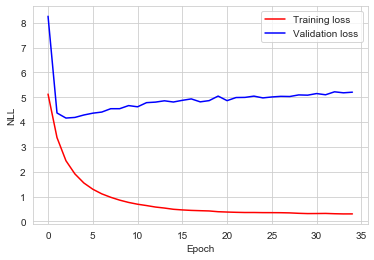

In [19]:
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot).cuda()
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx).cuda()

# Forward pass
outputs = net.forward(inputs_one_hot).data.cpu().numpy()


# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [20]:
inputs, targets = training_set[50]
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot).cuda()
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx).cuda()

# Forward pass
outputs = net.forward(inputs_one_hot).data.cpu().numpy()

inputstr = ' '.join(inputs)

targetstr = ' '.join(targets)

predictedSeq = [idx_to_word[np.argmax(output)] for output in outputs]
teststr = ' '.join(predictedSeq)

print('\nInput sequence:')
print(inputstr)

print('\nTarget sequence:')
print(targetstr)

print('\nPredicted sequence:')
print(teststr)


Input sequence:
shares its cooldown with other guard skills ( steelskin and immortal call )

Target sequence:
its cooldown with other guard skills ( steelskin and immortal call ) .

Predicted sequence:
its cooldown with other guard skills ( steelskin and molten call ) .


In [30]:
count = 0

full_story = 'elemental'
phrase = [full_story]

while count < 30:
    net.eval()
    inputs = phrase
    
    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)

    # Convert input to tensor
    inputs_one_hot = torch.Tensor(inputs_one_hot).cuda()
    inputs_one_hot = inputs_one_hot.permute(0, 2, 1)


    outputs = net.forward(inputs_one_hot).data.cpu().numpy()
        
    next_word = outputs[-1]
    
    floor = min(next_word)
    next_word = [x - floor for x in next_word]
    next_word /= sum(next_word)
    count+=1
    
    word_index = np.argmax(next_word)
    
    
    predictedSeq = idx_to_word[word_index]
    
    
    teststr = ' '.join(predictedSeq)
    full_story += ' ' + predictedSeq
    phrase = full_story.split(' ')

print(full_story)

elemental overload now causes ailments to never count as being from critical strikes ( previously caused ailments from critical strikes to have no damage multiplier ) . poison at gem level
